## Shelf slope and vertical transport through lid correction 

In [2]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

#from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [3]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
#lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import MetricsPythonTools as mpt


In [4]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [5]:
# plotting functions
def plotCanyonPos(ax,UpX,DnX):
    ax.axvline(UpX,color='0.70',linestyle='--')
    ax.axvline(DnX,color='0.70',linestyle='--')


In [6]:
#Exp
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc' 
CGridOut = Dataset(CGrid)

CGridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc' 
CGridNoCOut = Dataset(CGridNoC)

State = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc' 
StateNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/stateGlob.nc' 




In [7]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 22 # number of tracers in total (CNT =22, 3D = 4, total = 19)

rc = CGridNoCOut.variables['RC']
dxf = CGridNoCOut.variables['dxF']
xc = rout.getField(CGridNoC, 'XC') # x coords tracer cells
yc = rout.getField(CGridNoC, 'YC') # y coords tracer cells

rA = rout.getField(CGridNoC, 'rA') 
depth = rout.getField(CGrid, 'Depth')
drF = CGridNoCOut.variables['drF'] # vertical distance between faces
drC = CGridNoCOut.variables['drC'] # vertical distance between centers

hFacC = rout.getField(CGridNoC, 'HFacC')
mask_NoC = rout.getMask(CGridNoC, 'HFacC')

labels = ['Kv: out=1E-7, in=1E-3, Kiso=1','Kv: out=1E-7,in=1E-4, Kiso=1','Kv: out=1E-5, in=1E-3, Kiso=1',
          'Kv: out=1E-5, in=1E-4, Kiso=1','Kv=1E-5, Kiso=1','Kv=1E-4, Kiso=1','Kv=1E-3, Kiso=1','Kv=3.8E-5, Kiso=10',
          'Kv=2.8E-5, Kiso=10','Kv=1.3E-5, Kiso=10','Kv_noc=1E-5, Kiso=1','Kv_noc=1E-4, Kiso=1','Kv_noc=1E-3, Kiso=1',
          'Kv=1E-5, Kiso=10','Kv=1E-4, Kiso=10','Kv=1E-3, Kiso=10','Kv=1E-5, Kiso=0.1','Kv=1E-4, Kiso=0.1','Kv=1E-3, Kiso=0.1',
          'Kv=3.8E-5, Kiso=1','Kv=2.8E-5, Kiso=1','Kv=1.3E-5, Kiso=1']

times = np.arange(0,nt,1)

#print(drC[:])
#print(np.shape(drC))

In [8]:
def VerticalTransportLid(Tr,MaskC,nzlim,rA,hFacC,drF,yin,yfin,zfin,xi,yi):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : first across-shore index of shelf division
    yfin  : final across-shore index of shelf division
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mpt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:yfin,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:yfin,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:yfin,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:yfin,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:yfin,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:yfin,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc, Total_Tracer)

y index for shelfbreak, 100m depth and 50 m depth
depth[227,0] is 147.753973 
depth[267,0] is 100.000000 
depth[359,0] is 20.000000 


/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


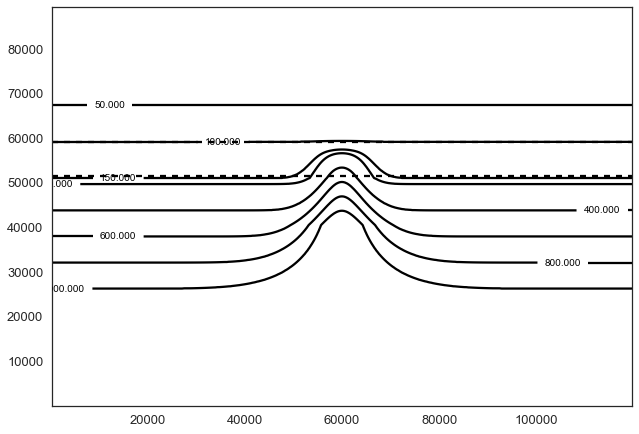

In [9]:
contour = plt.contour(xc[1,:],yc[:,1],depth,[50,100,150,200,400,600,800,1000,1200],colors='k')
plt.clabel(contour, inline=1, fontsize=10)
plt.axhline(yc[267,1],color='k',linestyle='--')
plt.axhline(yc[227,1],color='k',linestyle='--')

print('y index for shelfbreak, 100m depth and 50 m depth')
print('depth[227,0] is %f ' % depth[227,0])
print('depth[267,0] is %f ' % depth[267,0])
print('depth[359,0] is %f ' % depth[359,0])

In [10]:
W = rout.getField(State, 'W')

## Calculate slope

y index for shelfbreak, 100m depth and 50 m depth
depth[227,0] is 147.753973 m and yc[227,0] is 51670.679012 m
depth[267,0] is 100.000000 m and yc[267,0] is 59445.726983 m
depth[359,0] is 20.000000 m and yc[359,0] is 89781.388162 m


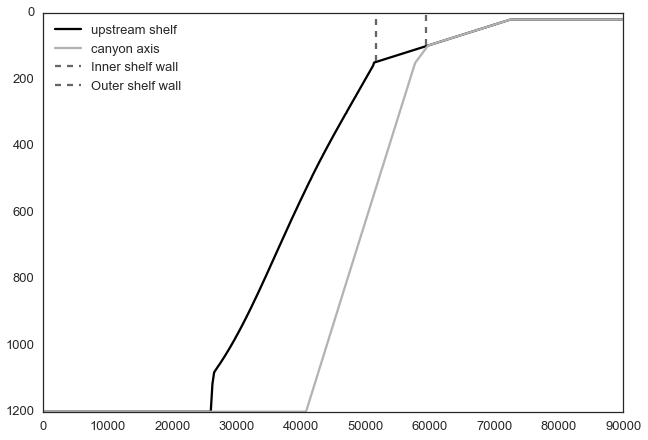

In [49]:
plt.plot(yc[:,1],depth[:,100],color='k',label='upstream shelf')
plt.plot(yc[:,1],depth[:,180],color='0.70',label='canyon axis')

plt.axvline(yc[267,1],ymin=0.92,ymax=1.0,color='0.40',linestyle='--',label = 'Inner shelf wall')
plt.axvline(yc[227,1],ymin =0.88,ymax=1.0,color='0.40',linestyle='--',label = 'Outer shelf wall')

plt.gca().invert_yaxis()
plt.legend(loc=0)
print('y index for shelfbreak, 100m depth and 50 m depth')
print('depth[227,0] is %f m and yc[227,0] is %f m' % (depth[227,0],yc[227,0]))
print('depth[267,0] is %f m and yc[267,0] is %f m'  % (depth[267,0],yc[267,0]))
print('depth[359,0] is %f m and yc[359,0] is %f m' % (depth[359,0],yc[359,0]))

In [46]:
slope = -(depth[267,1]-depth[227,1])/(yc[267,1]-yc[227,1]) # I want it to be positive for this case

print('The slope is:')
print(slope)

alpha = atan(slope)
print(' ')
print('The associated angle is (rad):')
print(alpha)


print(' ')
print('In deg:')
print(degrees(alpha))


The slope is:
0.00614195218077
 
The associated angle is (rad):
0.00614187495038
 
In deg:
0.351903512954


### Get indices of the shelf bottom from flat shelf mask

In [77]:
#IndShelfBot = 
ind = np.ma.argmax(mask_NoC[:,226:267,:], axis=0, fill_value=None)
print(np.shape(ind))
print(ind[:,240])

(41, 360)
[30 30 30 30 29 29 29 29 29 28 28 28 28 27 27 27 27 26 26 26 26 26 25 25 25
 25 24 24 24 24 23 23 23 23 22 22 22 22 21 21 21]


<matplotlib.contour.QuadContourSet instance at 0x7ff8cf501950>

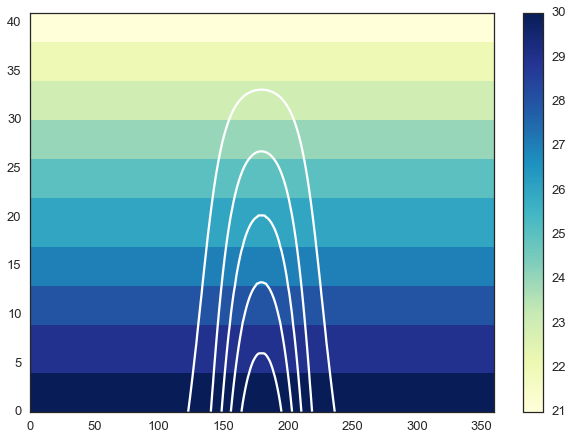

In [78]:
pcol=plt.pcolor(ind, cmap = 'YlGnBu')
plt.colorbar(pcol)
plt.contour(depth[225:267,:],colors = 'w')

<matplotlib.colorbar.Colorbar instance at 0x7ff8ce071a28>

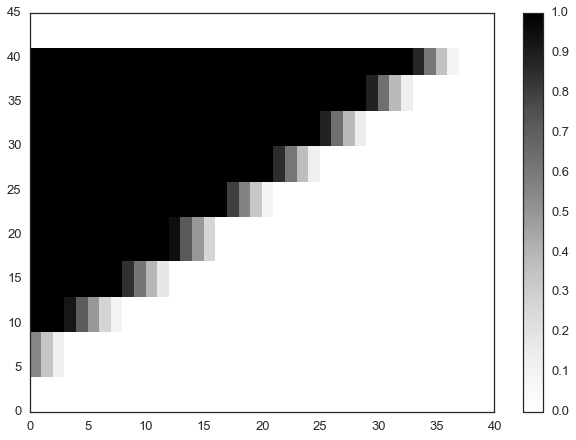

In [79]:
pcol = plt.pcolor(hFacC[ind[:,180],227:267,180])
plt.colorbar(pcol)
#print(hFacC[ind[:,180],227:267,180])

In [94]:
nt = np.shape(W)[0]
nx = np.shape(W)[2]
nyind = np.shape(ind)[0]

Wind = np.zeros((nt,1,nyind,nx))

for xx in np.arange(359):
    for yy in  np.arange(0,41,1):
        #print(yy)
        for tt in np.arange(0,nt,1):
            Wind[tt,0,yy,xx] = W[tt,ind[yy,xx],yy+227,xx]

print(np.shape(Wind))


(19, 1, 41, 360)


<matplotlib.colorbar.Colorbar instance at 0x7ff89fbbbb48>

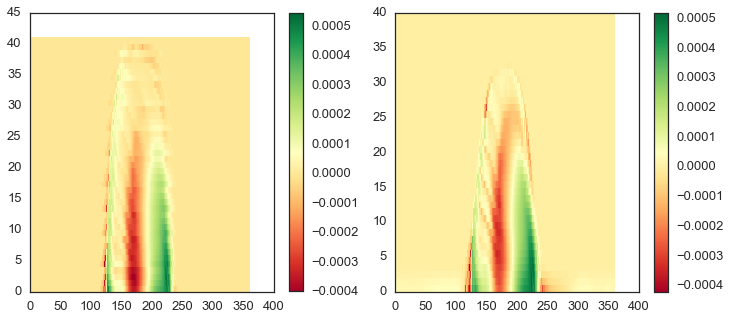

In [104]:
fig = plt.figure(figsize=(12,5))
ax1= plt.subplot(1,2,1)

pcol1 = ax1.pcolor(Wind[10,0,:,:]*np.cos(alpha), cmap = 'RdYlGn')
plt.colorbar(pcol1)

ax2 = plt.subplot(1,2,2)

pcol2 = ax2.pcolor(W[10,29,227:267,:], cmap = 'RdYlGn')
plt.colorbar(pcol2)
